Real inital desity n_i = 0.0123

Elapsed time 99.222589


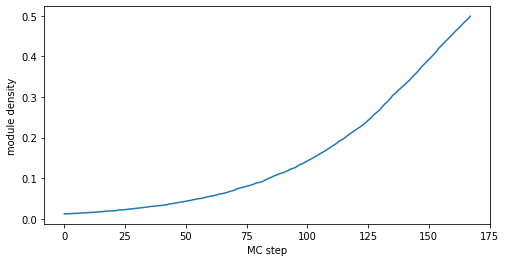

In [14]:
"""
Evaluation of simple proximity dynamics model by counting method.


(i) Model the network dynamics of solar panel installation
    by assuming panel proximity as the main determining variable.
(ii) Evaluate the early diffusion by counting solar panels in surrounding circle areas (radius r)
    For each new panel at time t-1, the number of new panels within A_r at time t (t+1, ...) is calculated

"""
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

import pandas as pd
# ----------------
# model parameters
# ----------------
# 
# all distances are normalized by r0 = 0.21 km
# i.e. r = 20 corresponds to r_real = 210 m * 20 = 4.2 km
# 
# $ Fresno area (about 270 km^2)
# -> model area 256 km^2 (= 16 x 16 km^2)

r0 = 0.21 # km

# number of addresses
## original number N=3*10^5 
## rescale for computability (limited memory capacity)
NO = 300000
scale = 1.0 / 30
N = int(NO * scale)

# area under test L^2
# rescale by sqrt(scale)
L = 16.0 / r0 * sqrt(scale) # km

# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
n0 = 0.01

seed(0)

# create pseudo-random locations
locs = rand(N, 2) * L
all_dist = squareform(pdist(locs))

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    new_panels = []
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]
            if state[i]: 
                new_panels.append(i)
            
    return np.array(new_panels, dtype='int32')

# save densities for visualizing global diffusion
densities = []

#----------------
# run simulation
#----------------
n_steps = 500 # MC steps

tol = 1e-3
period = 10 # measured in MC steps

# determine radii and intervals of interest
radii = np.array([0.5, 1.0, 2.0, 4.0], dtype='float32') * sqrt(scale) / r0
intervals = np.array([1, 2, 3, 4], dtype='int8') # in periods

# indices of locs which change from state 
# False to True in a given period
new_panels = np.array([], dtype='int32')
last_new_panels = np.array([], dtype='int32')
new_panels_history = []


results = []
results_scaled = []

countP = 0
tStart = time()

for step in range(n_steps):
    
    countP += 1
    current_new_panels = mc_step(locs, state)
    new_panels = np.concatenate((new_panels, current_new_panels), axis=None)
    
    n = density(state)
    if n > 0.5:
        break
    densities.append(n)
    
    if countP >= period:
        # initialize tables for saving data
        panel_count_table = np.zeros((radii.size, intervals.size))
        panel_count_table_scaled = np.zeros((radii.size, intervals.size))
        
        # bool array for vectorized computation
        loc_is_new_panel = np.zeros(N, dtype='bool')
        loc_is_new_panel[new_panels] = True
        
        # fill panel count tables
        # for each last new panel
        # calculate relative nb of new panels within A_r        
        for k, radius in enumerate(radii):
            for j, timestamp in enumerate(intervals):
                if timestamp > len(new_panels_history): continue
    
                last_new_panels = new_panels_history[-timestamp]
                    
                # for vectorized computaion
                loc_is_last_new_panel = np.zeros(N, dtype='bool')
                loc_is_last_new_panel[last_new_panels] = True

                neighbourhood = all_dist < radius
                helper = np.tile(loc_is_new_panel, (N, 1))
                neighbourhood_panels = np.logical_and(helper, neighbourhood)

                n_neighbours = np.sum(neighbourhood, axis=1)[loc_is_last_new_panel]
                n_panels = np.sum(neighbourhood_panels, axis=1)[loc_is_last_new_panel]
                n_panels_rel = n_panels / n_neighbours
                avg_n_panels_rel = np.sum(n_panels_rel) / n_panels_rel.size
                
                panel_count_table[k][j] = avg_n_panels_rel
                panel_count_table_scaled[k][j] = avg_n_panels_rel / new_panels.size
        
        results.append(panel_count_table)
        results_scaled.append(panel_count_table_scaled)
        new_panels_history.append(new_panels)
        new_panels = np.array([], dtype='int32')
        countP = 0
    # END IF
    


elapsed = time() - tStart
print("Elapsed time %f" % elapsed)

# output
fig = plt.figure(figsize=(8, 4))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()

df = pd.DataFrame()

In [15]:
print("Avg relative new panels in area A_r/r0 after xxx Periods")

mean = np.zeros((radii.size, intervals.size))

c = 0
for i in range(3, len(results)):
    mean += results[i]
    c += 1
                
mc = mean / c

print("")

header = "r/r0 |\t"
for i, inter in enumerate(intervals):
    header += "%d P \t \t" % inter

print(header)
print("")

for j, r in enumerate(radii):
    line = "%.2f |\t" % r
    for i, inter in enumerate(intervals):
        line += "%.3e \t" % mc[j, i]
    
    print(line)

Avg relative new panels in area A_r/r0 after xxx Periods

r/r0 |	1 P 	 	2 P 	 	3 P 	 	4 P 	 	

0.43 |	3.374e-02 	3.358e-02 	3.318e-02 	3.285e-02 	
0.87 |	3.415e-02 	3.423e-02 	3.463e-02 	3.372e-02 	
1.74 |	3.455e-02 	3.442e-02 	3.438e-02 	3.371e-02 	
3.48 |	3.450e-02 	3.434e-02 	3.443e-02 	3.374e-02 	


In [16]:
print("Avg relative new panels in area A_r/r0 after xxx Periods normalized by the total count of new panels")

mean = np.zeros((radii.size, intervals.size))

c = 0
for i in range(3, len(results_scaled)):
    mean += results_scaled[i]
    c += 1
                
mc = mean / c

print("")

header = "r/r0 |\t"
for i, inter in enumerate(intervals):
    header += "%d P \t \t" % inter

print(header)
print("")

for j, r in enumerate(radii):
    line = "%.2f |\t" % r
    for i, inter in enumerate(intervals):
        line += "%.3e \t" % mc[j, i]
    
    print(line)

Avg relative new panels in area A_r/r0 after xxx Periods normalized by the total count of new panels

r/r0 |	1 P 	 	2 P 	 	3 P 	 	4 P 	 	

0.43 |	1.049e-04 	1.020e-04 	1.011e-04 	9.525e-05 	
0.87 |	1.066e-04 	1.058e-04 	1.079e-04 	9.949e-05 	
1.74 |	1.064e-04 	1.062e-04 	1.065e-04 	9.918e-05 	
3.48 |	1.063e-04 	1.061e-04 	1.059e-04 	9.788e-05 	


Real inital desity n_i = 0.0073

Elapsed time 16.310954


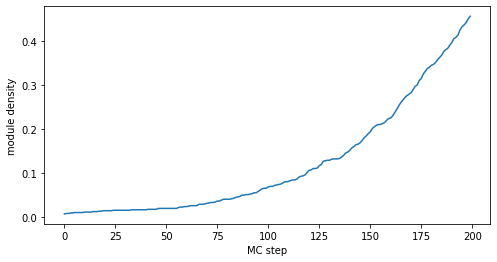

<ipython-input-72-fa1cee0447b5>:185: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


Text(0.5, 0, 'log r')

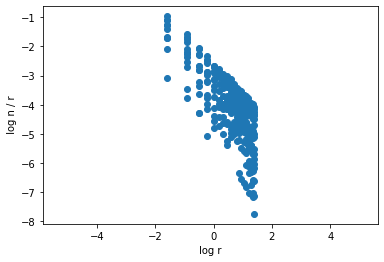

In [72]:
"""
Evaluation of simple proximity dynamics model by counting method.


(i) Model the network dynamics of solar panel installation
    by assuming panel proximity as the main determining variable.
(ii) Evaluate the early diffusion by counting solar panels in surrounding circle areas (radius r)
    For each new panel at time t-1, the number of new panels within A_r at time t (t+1, ...) is calculated

"""
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

import pandas as pd
# ----------------
# model parameters
# ----------------
# 
# all distances are normalized by r0 = 0.21 km
# i.e. r = 20 corresponds to r_real = 210 m * 20 = 4.2 km
# 
# $ Fresno area (about 270 km^2)
# -> model area 256 km^2 (= 16 x 16 km^2)

r0 = 0.21 # km

# number of addresses
## original number N=3*10^5 
## rescale for computability (limited memory capacity)
NO = 30000
scale = 1.0 / 30
N = int(NO * scale)

# area under test L^2
# rescale by sqrt(scale)
L = 16.0 / r0 * sqrt(scale) # km

# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
n0 = 0.01

seed(0)

# create pseudo-random locations
#locs = rand(N, 2) * L

# create equidistant locations
sqrtN = int(sqrt(N))
x = np.arange(0, sqrtN) * L / sqrtN
y = np.arange(0, sqrtN) * L / sqrtN
xx, yy = np.meshgrid(x, y, sparse=False)
locs = np.stack((xx.flatten(), yy.flatten()), 1)
all_dist = squareform(pdist(locs))

N = int(sqrtN * sqrtN)

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    new_panels = []
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]
            if state[i]: 
                new_panels.append(i)
            
    return np.array(new_panels, dtype='int32')

def count_new_panels_at_r(r, old_panel, new_panels, locs):
    # count new panels at distance r
    count = 0
    n = 0
    tol = 0.4 # km
    dmin2 = (r - tol) * (r - tol)
    dmax2 = (r + tol) * (r + tol)
    
    x0, y0 = locs[old_panel]
    for i, (x, y) in enumerate(locs):
        m = (x0-x) * (x0-x) + (y0-y) * (y0-y)
        if dmin2 < m and dmax2 > m:
            if i in new_panels:
                count += 1
            n += 1
    
    if n == 0:
        return 0
    return count * 1./n

# save densities for visualizing global diffusion
densities = []

#----------------
# run simulation
#----------------
n_steps = 200 # MC steps

tol = 1e-3
period = 10 # measured in MC steps

# determine radii and intervals of interest
#radii = np.array([0.5, 1.0, 2.0, 4.0], dtype='float32') * sqrt(scale) / r0
#r_start = np.log(0.2 * sqrt(scale) / r0)
#r_stop = np.log(4.0 * sqrt(scale) / r0)
radii = np.linspace(0.2, 4.0, 20, endpoint=True)

# indices of locs which change from state 
# False to True in a given period
new_panels = np.array([], dtype='int32')
old_new_panels = np.array([], dtype='int32')

countP = 0
tStart = time()

data = np.array([], dtype='float64')

for step in range(n_steps):
    
    countP += 1
    current_new_panels = mc_step(locs, state)
    new_panels = np.concatenate((new_panels, current_new_panels), axis=None)
    
    n = density(state)
    if n > 0.6:
        break
    densities.append(n)
    
    if countP >= period:
        
        for r in radii:
            counts = []
            for old_panel in old_new_panels:
                n = count_new_panels_at_r(r, old_panel, new_panels, locs)
                counts.append(n)
            
            if len(counts) > 0:
                data = np.append(data, [r, np.mean(counts) / r])
            
        
        old_new_panels = new_panels
        new_panels = np.array([], dtype='int32')
        countP = 0
    
    # END IF
    


elapsed = time() - tStart
print("Elapsed time %f" % elapsed)

# output
fig = plt.figure(figsize=(8, 4))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()

data = data.reshape((int(data.shape[0] / 2), 2))
data = np.log(data)
plt.plot(data[:, 0], data[:, 1], 'o')
plt.axis('equal')
plt.ylabel(" log n / r")
plt.xlabel("log r")

Real inital desity n_i = 0.0077

Elapsed time 95.329707


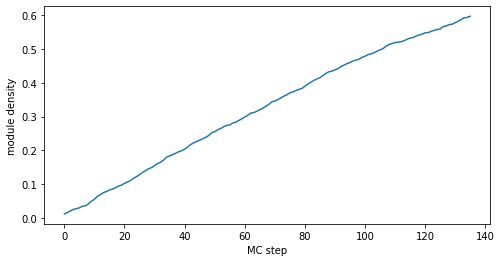

Text(0.5, 0, 'log r')

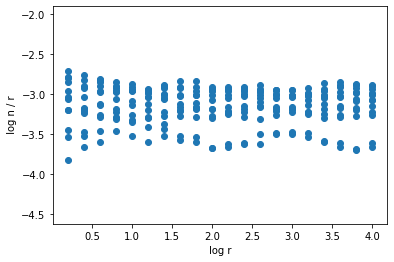

In [119]:
"""
Evaluation of simple proximity dynamics model by counting method.


(i) Model the network dynamics of solar panel installation
    by assuming panel proximity as the main determining variable.
(ii) Evaluate the early diffusion by counting solar panels in surrounding circle areas (radius r)
    For each new panel at time t-1, the number of new panels within A_r at time t (t+1, ...) is calculated

"""
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt, extract
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

import pandas as pd
# ----------------
# model parameters
# ----------------
# 
# all distances are normalized by r0 = 0.21 km
# i.e. r = 20 corresponds to r_real = 210 m * 20 = 4.2 km
# 
# $ Fresno area (about 270 km^2)
# -> model area 256 km^2 (= 16 x 16 km^2)

r0 = 0.21 # km

# number of addresses
## original number N=3*10^5 
## rescale for computability (limited memory capacity)
NO = 60000
scale = 1.0 / 30
N = int(NO * scale)

# area under test L^2
# rescale by sqrt(scale)
L = 16.0 / r0 * sqrt(scale) # km

# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
n0 = 0.01

seed(0)

# create pseudo-random locations
#locs = rand(N, 2) * L

# create equidistant locations
sqrtN = int(sqrt(N))
x = np.arange(0, sqrtN) * L / sqrtN
y = np.arange(0, sqrtN) * L / sqrtN
xx, yy = np.meshgrid(x, y, sparse=False)
locs = np.stack((xx.flatten(), yy.flatten()), 1)
all_dist = squareform(pdist(locs))
N = int(sqrtN * sqrtN)


# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N)
    new_panels = []
    for i, panel in enumerate(state):
        if not panel:
            # get distance of nearest solar cell
            cell_distances = extract(state, all_dist[i])
            d = np.min(cell_distances)
            # set probability
            scale = 0.01
            p = scale * exp(-d)
            state[i] = p > rnds[i]
            if state[i]: 
                new_panels.append(i)
                
    return np.asarray(new_panels, dtype='int32')

def count_new_panels_at_r(r, old_panel, new_panels, locs):
    # count new panels at distance r
    count = 0
    n = 0
    tol = 0.3 # km
    dmin2 = (r - tol) * (r - tol)
    dmax2 = (r + tol) * (r + tol)
    
    x0, y0 = locs[old_panel]
    for i, (x, y) in enumerate(locs):
        m = (x0-x) * (x0-x) + (y0-y) * (y0-y)
        if dmin2 < m and dmax2 > m:
            if i in new_panels:
                count += 1
            n += 1
    
    if n == 0:
        return 0
    return count * 1./n

# save densities for visualizing global diffusion
densities = []

#----------------
# run simulation
#----------------
n_steps = 150 # MC steps

tol = 1e-3
period = 10 # measured in MC steps

# determine radii and intervals of interest
#radii = np.array([0.5, 1.0, 2.0, 4.0], dtype='float32') * sqrt(scale) / r0
#r_start = np.log(0.2 * sqrt(scale) / r0)
#r_stop = np.log(4.0 * sqrt(scale) / r0)
radii = np.linspace(0.2, 4.0, 20, endpoint=True)

# indices of locs which change from state 
# False to True in a given period
new_panels = np.array([], dtype='int32')
old_new_panels = np.array([], dtype='int32')

countP = 0
tStart = time()

data = np.array([], dtype='float64')

for step in range(n_steps):
    
    countP += 1
    current_new_panels = mc_step(locs, state)
    new_panels = np.concatenate((new_panels, current_new_panels), axis=None)
    
    n = density(state)
    if n > 0.6:
        break
    densities.append(n)
    
    if countP >= period:
        
        for r in radii:
            counts = []
            for old_panel in old_new_panels:
                n = count_new_panels_at_r(r, old_panel, new_panels, locs)
                counts.append(n)
            
            if len(counts) > 0:
                data = np.append(data, [r, np.mean(counts)])
            
        
        old_new_panels = new_panels
        new_panels = np.array([], dtype='int32')
        countP = 0
    
    # END IF
    


elapsed = time() - tStart
print("Elapsed time %f" % elapsed)

# output
fig = plt.figure(figsize=(8, 4))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()

df = pd.DataFrame()
data = data.reshape((int(data.shape[0] / 2), 2))
#data = np.log(data)
plt.plot(data[:, 0], np.log(data[:, 1]), 'o')
plt.axis('equal')
plt.ylabel(" log n / r")
plt.xlabel("log r")

<ipython-input-116-83395e1ef471>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1./x)
<ipython-input-116-83395e1ef471>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1./np.exp(x) * 1./x)


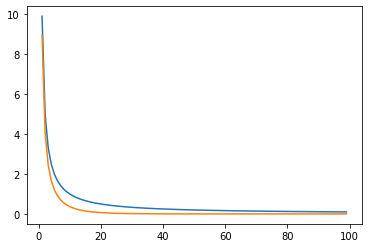

In [116]:
x = np.linspace(0, 10, 100)
plt.plot(1./x)
plt.plot(1./np.exp(x) * 1./x)

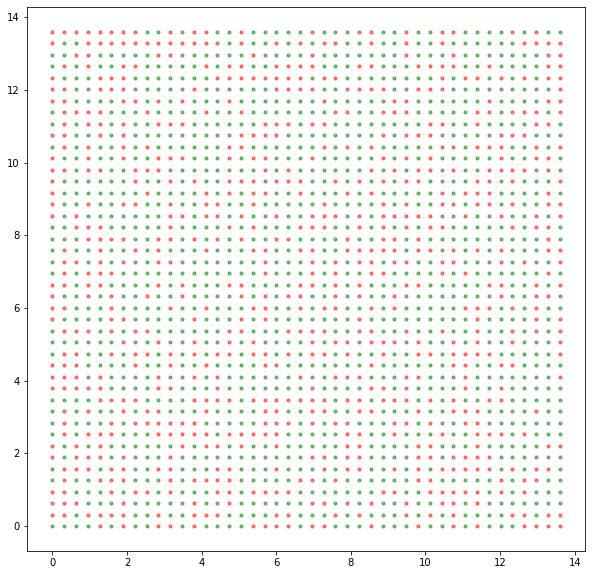

In [117]:
# add figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)


cells = locs[state == True]
empty = locs[state == False]

ax.scatter(cells[:,0], cells[:,1], color='green', s= 10, alpha=0.5)
ax.scatter(empty[:,0], empty[:,1], color='red', s=10, alpha=0.5)
        

======= Scale : 2.0
======= Scale : 3.3956818716219397
======= Scale : 5.76532768663094
======= Scale : 9.788609354726372
======= Scale : 16.619501667116637
======= Scale : 28.21727026320928
======= Scale : 47.90843654971832
======= Scale : 81.34090474481421
======= Scale : 138.1039178316463
======= Scale : 234.47848509044363
The Hausdorff dimension is 2.564986024365422


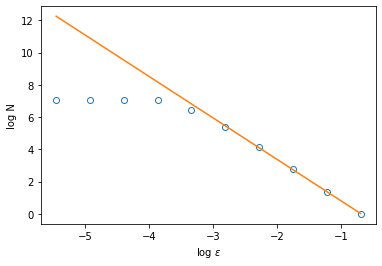

In [118]:
# computing the fractal dimension
#considering only scales in a logarithmic list
import numpy as np

data = locs[state]
Lx = L
Ly = L
scales=np.logspace(np.log10(2), 2.6, num=10, endpoint=False, base=10)
Ns=[]
# looping over several scales
for scale in scales:
    print ("======= Scale :",scale)
    # computing the histogram
    H, edges=np.histogramdd(data, bins=(np.linspace(0,Lx,int(scale)),np.linspace(0,Ly,int(scale))))
    Ns.append(np.sum(H>0))

eps = 1./scales
# linear fit, polynomial of degree 1
coeffs=np.polyfit(np.log(eps)[:5], np.log(Ns)[:5], 1)
 
pl.plot(np.log(eps),np.log(Ns), 'o', mfc='none')
pl.plot(np.log(eps), np.polyval(coeffs,np.log(eps)))
pl.xlabel('log $\epsilon$')
pl.ylabel('log N')
 
print ("The Hausdorff dimension is", -coeffs[0]) #the fractal dimension is the OPPOSITE of the fitting coefficient

In [37]:
H

array([[ 5.,  2.,  2.,  3.,  6.,  7.,  3.,  1.,  5.,  1.,  2.,  1.,  2.],
       [ 2.,  2.,  4.,  1., 11.,  5.,  2.,  4.,  4.,  0.,  3.,  4.,  1.],
       [ 3.,  7.,  7.,  2.,  7.,  9.,  4.,  4.,  1.,  3.,  3.,  2.,  2.],
       [ 1.,  8.,  8.,  8.,  4.,  6.,  7.,  4.,  5.,  4.,  3.,  2.,  3.],
       [ 0.,  5.,  5.,  3.,  6.,  6.,  4.,  4.,  1.,  4.,  3.,  4.,  5.],
       [ 3.,  4.,  6.,  6.,  5.,  4.,  3.,  5.,  3.,  3.,  3.,  2.,  3.],
       [ 2.,  3.,  1.,  4.,  5.,  1.,  4.,  8.,  5.,  7.,  3.,  6.,  6.],
       [ 3.,  1.,  1.,  3.,  5.,  5.,  3.,  2.,  4.,  4.,  2.,  5.,  5.],
       [ 2.,  5.,  0.,  3.,  1.,  3.,  3.,  2.,  1.,  5.,  3.,  2.,  7.],
       [ 0.,  1.,  1.,  3.,  4.,  5.,  2.,  1.,  1.,  4.,  3.,  5.,  3.],
       [ 1.,  1.,  2.,  2.,  4.,  2.,  1.,  5.,  1.,  1.,  2.,  4.,  9.],
       [ 1.,  4.,  3.,  0.,  0.,  1.,  2.,  1.,  1.,  4.,  2.,  1.,  2.],
       [ 2.,  0.,  0.,  0.,  1.,  1.,  1.,  3.,  4.,  3.,  2.,  2.,  2.]])

In [59]:
H, edges=np.histogramdd(data, bins=(np.linspace(0,Lx,100),np.linspace(0,Ly,100)))
H

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [107]:
int(10**np.log10(2))

2

Real inital desity n_i = 0.0090

Elapsed time 17.906590


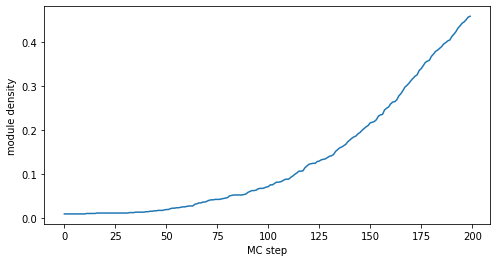

<ipython-input-1-b56a4dbfb4ea>:185: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


Text(0.5, 0, 'log r')

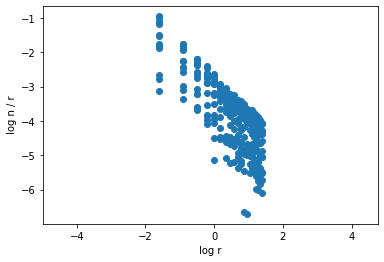

In [1]:
"""
Evaluation of simple proximity dynamics model by counting method.


(i) Model the network dynamics of solar panel installation
    by assuming panel proximity as the main determining variable.
(ii) Evaluate the early diffusion by counting solar panels in surrounding circle areas (radius r)
    For each new panel at time t-1, the number of new panels within A_r at time t (t+1, ...) is calculated

"""
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

import pandas as pd
# ----------------
# model parameters
# ----------------
# 
# all distances are normalized by r0 = 0.21 km
# i.e. r = 20 corresponds to r_real = 210 m * 20 = 4.2 km
# 
# $ Fresno area (about 270 km^2)
# -> model area 256 km^2 (= 16 x 16 km^2)

r0 = 0.21 # km

# number of addresses
## original number N=3*10^5 
## rescale for computability (limited memory capacity)
NO = 30000
scale = 1.0 / 30
N = int(NO * scale)

# area under test L^2
# rescale by sqrt(scale)
L = 16.0 / r0 * sqrt(scale) # km

# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
n0 = 0.01

seed(0)

# create pseudo-random locations
locs = rand(N, 2) * L

# create equidistant locations
#sqrtN = int(sqrt(N))
#x = np.arange(0, sqrtN) * L / sqrtN
#y = np.arange(0, sqrtN) * L / sqrtN
#xx, yy = np.meshgrid(x, y, sparse=False)
#locs = np.stack((xx.flatten(), yy.flatten()), 1)
all_dist = squareform(pdist(locs))

#N = int(sqrtN * sqrtN)

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    new_panels = []
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]
            if state[i]: 
                new_panels.append(i)
            
    return np.array(new_panels, dtype='int32')

def count_new_panels_at_r(r, old_panel, new_panels, locs):
    # count new panels at distance r
    count = 0
    n = 0
    tol = 0.4 # km
    dmin2 = (r - tol) * (r - tol)
    dmax2 = (r + tol) * (r + tol)
    
    x0, y0 = locs[old_panel]
    for i, (x, y) in enumerate(locs):
        m = (x0-x) * (x0-x) + (y0-y) * (y0-y)
        if dmin2 < m and dmax2 > m:
            if i in new_panels:
                count += 1
            n += 1
    
    if n == 0:
        return 0
    return count * 1./n

# save densities for visualizing global diffusion
densities = []

#----------------
# run simulation
#----------------
n_steps = 200 # MC steps

tol = 1e-3
period = 10 # measured in MC steps

# determine radii and intervals of interest
#radii = np.array([0.5, 1.0, 2.0, 4.0], dtype='float32') * sqrt(scale) / r0
#r_start = np.log(0.2 * sqrt(scale) / r0)
#r_stop = np.log(4.0 * sqrt(scale) / r0)
radii = np.linspace(0.2, 4.0, 20, endpoint=True)

# indices of locs which change from state 
# False to True in a given period
new_panels = np.array([], dtype='int32')
old_new_panels = np.array([], dtype='int32')

countP = 0
tStart = time()

data = np.array([], dtype='float64')

for step in range(n_steps):
    
    countP += 1
    current_new_panels = mc_step(locs, state)
    new_panels = np.concatenate((new_panels, current_new_panels), axis=None)
    
    n = density(state)
    if n > 0.6:
        break
    densities.append(n)
    
    if countP >= period:
        
        for r in radii:
            counts = []
            for old_panel in old_new_panels:
                n = count_new_panels_at_r(r, old_panel, new_panels, locs)
                counts.append(n)
            
            if len(counts) > 0:
                data = np.append(data, [r, np.mean(counts) / r])
            
        
        old_new_panels = new_panels
        new_panels = np.array([], dtype='int32')
        countP = 0
    
    # END IF
    


elapsed = time() - tStart
print("Elapsed time %f" % elapsed)

# output
fig = plt.figure(figsize=(8, 4))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()

data = data.reshape((int(data.shape[0] / 2), 2))
data = np.log(data)
plt.plot(data[:, 0], data[:, 1], 'o')
plt.axis('equal')
plt.ylabel(" log n / r")
plt.xlabel("log r")

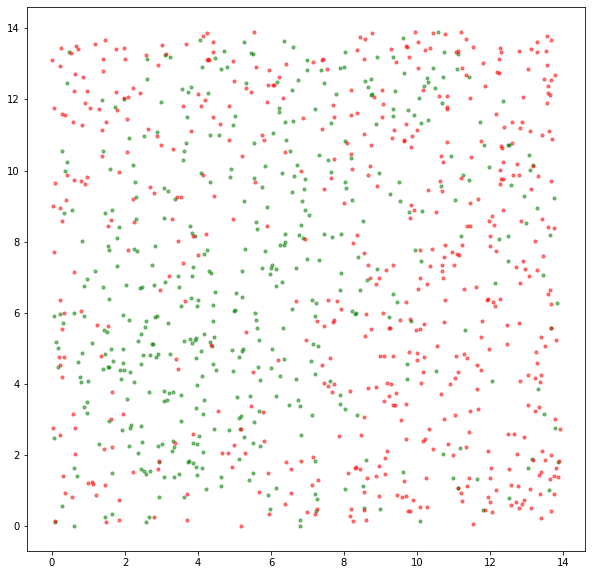

In [2]:
# add figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)


cells = locs[state == True]
empty = locs[state == False]

ax.scatter(cells[:,0], cells[:,1], color='green', s= 10, alpha=0.5)
ax.scatter(empty[:,0], empty[:,1], color='red', s=10, alpha=0.5)
        

======= Scale : 13.91041415886136
======= Scale : 6.95520707943068
======= Scale : 3.47760353971534
======= Scale : 1.73880176985767
======= Scale : 0.869400884928835
======= Scale : 0.4347004424644175
======= Scale : 0.21735022123220876
======= Scale : 0.10867511061610438
======= Scale : 0.05433755530805219
The Hausdorff dimension is 1.1282086744438398


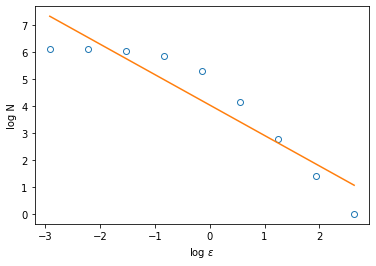

In [30]:
# computing the fractal dimension
#considering only scales in a logarithmic list
import numpy as np

data = locs[state]
Lx = L
Ly = L
scales=L * 1./2**(np.arange(0, 9, 1))
Ns=[]
# looping over several scales
for scale in scales:
    print ("======= Scale :",scale)
    # computing the histogram
    H, edges=np.histogramdd(data, bins=(np.arange(0,Lx+scale/2,scale),np.arange(0,Ly+scale/2,scale)))
    Ns.append(np.sum(H>0))

eps = scales
# linear fit, polynomial of degree 1
coeffs=np.polyfit(np.log(eps)[:], np.log(Ns)[:], 1)
 
plt.plot(np.log(eps),np.log(Ns), 'o', mfc='none')
plt.plot(np.log(eps), np.polyval(coeffs,np.log(eps)))
plt.xlabel('log $\epsilon$')
plt.ylabel('log N')
 
print ("The Hausdorff dimension is", -coeffs[0]) #the fractal dimension is the OPPOSITE of the fitting coefficient